### Multi-Response Logistic Regression 

#### Cross-entropy loss
$$H(p,q) = -\sum_{j=1}^k p_j \ln(q_j)$$
where k is the number of classes

#### Encode
Encode each lable $j \in {1,...,k}$ as $\tilde y_j = \mathbf{e}_j = (0,0,...,1,0,...,0)^T$ (jth coordinate being 1) <br>
Give real-value function $f: \mathbb{R}^d \rightarrow \mathbb{R}^k$, the predictor $\hat f$ predicts $j \in Y$ with probability $\dfrac{\exp(f(x)_j)}{\sum_{j=1}^k \exp(f(x)_j)}$, i.e. $\hat f: \mathbb{R}^d \rightarrow \Delta_k$ <br>
Hence the loss 
$$l(\tilde y_i, f(x)) = -\sum_{j=1}^k \tilde y_i \ln(\dfrac{\exp(f(x)_j)}{\sum_{j=1}^k \exp(f(x)_j)})
= -f(x)_y + \ln(\sum_{j=1}^k \exp(f(x)_j))$$
where y indicates the true lable of example $y_i$

#### Margin
$$ f(x)_y - \underset{j\ne y}{max} \: f(x)_j$$
Also we have 
$$l(\tilde y_i, f(x)) \approx -f(x)_y + \max_{j} f(x)_j$$
which means minimizing the loss is approximately maximizing the margin.

#### Stochastic Gradient Descent
Randomly select a mini-batch $B = \{ (x_i,y_i)\}$, $i = 1,...,b$, and calculate the empirical gradient on B. <br>
$$\mathbb{E} [\dfrac{1}{b} \sum_{i \in B} \nabla_\theta l(y_i, F(x_i,\theta^t))] = \nabla_\theta \hat R (\theta^t)$$
Unbiased


In [265]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [83]:
def softmax(y_linear):
    exp = np.exp((y_linear-np.max(y_linear,axis=1).reshape(-1,1)))
    norms = np.sum(exp,axis=1).reshape(-1,1)
    
    return exp/norms

In [196]:
def model(X,W,b):
    y_linear = np.dot(X,W)+b
    y_hat = softmax(y_linear)
    return y_hat

In [116]:
def cross_entropy(y_hat,y):
    return -np.sum(y*np.log(y_hat+1e-6))

In [43]:
def hot_vector(y,n,k):
    Y_til = np.zeros((n,k))
    for i in range(n):
        Y_til[i,y[i]] = 1
    
    return Y_til
        

In [197]:
def gradient(X,y,W,b):
    
    n,d = X.shape
    k = W.shape[1]
    # Convert y to hot-vectors with dimension n_sample x n_classes
    Y_tilde =  hot_vector(y,n,k)
    
    # Calculate gradient
    # f(x)_y
    part1 = X.T @ Y_tilde
    
    # Find max_j exp(f(x))_j
    fx = X@W
    max_value = fx.max(axis=1).reshape(-1,1)
    max_j = np.nonzero(fx==max_value)[1]
    max_j_tilde = hot_vector(max_j,n,k)
    part2 = X.T @ max_j_tilde
    
    gradW = -part1+part2
    gradb = np.repeat(1,k)
    
    return gradW,gradb

In [198]:
def multi_logistic_train(df_train,W0,b0,batchsize,eta=0.005):
    
    # Sample a mini-batch
    df_train_shuffled = df_train.sample(frac=1)
    X_train, y_train = np.array(df_train.iloc[:,1:]), np.array(df_train.iloc[:,0])
    #X_train = X_train/255
    
    for i in range(0,df_train_shuffled.shape[0], batchsize):
        X_mini = X_train[i:i+batchsize]
        y_mini = y_train[i:i+batchsize]
        
        gW,gb = gradient(X=X_mini, y=y_mini, W=W0, b=b0)
        
        W1 = W0 - eta*gW
        b1 = gb - eta*gb
    
    return W1, b1

In [204]:
def multi_logistic_predict(df_test, W1,b1):
    X_test, y_test = np.array(df_test.iloc[:,1:]), np.array(df_test.iloc[:,0])
    y_hat = model(X_test,W1,b1)
    
    max_j = np.nonzero(y_hat == y_hat.max(axis=1).reshape(-1,1))[1]
    y_predict = max_j.reshape(-1,1)
    
    return y_predict

In [253]:
"""putting everything together"""

if __name__ == '__main__':
    
    # Load data
    df_train = pd.read_csv("mnist_train.csv",header = None)
    df_test = pd.read_csv("mnist_test.csv",header = None)

    # Get data information
    n_train, d = df_train.iloc[:,1:].shape
    n_test = df_test.shape[0]
    k = len(np.unique(df_train.iloc[:,0]))

    # Tune minibatch
    # After tuning (not shown here), choose the best value of hyperparameters:
    batchsize = 3000
    epoch = 60
    eta = 0.001
    # Initial loss
    loss = []
    y_test = df_test.iloc[:,0]
    y_tild = hot_vector(y_test,n_test, k)
    y_init = multi_logistic_predict(df_test,W0,b0)
    y_init_tild = hot_vector(y_init, n_test, k)
    loss.append(cross_entropy(y_hat = y_init_tild, y = y_tild))

    # Training
    Err = []
    np.random.seed(1)
    W0 = np.random.normal(size =(d,k))
    b0 = np.random.normal(size=(k,))
    
    for i in range(epoch):

        W1,b1 = multi_logistic_train(df_train,W0, b0, batchsize, eta)

        y_predict = multi_logistic_predict(df_test,W1,b1)
        y_predict_tild = hot_vector(y_predict,n_test, k)
        loss.append(cross_entropy(y_tild,y_predict_tild))
        err = np.sum(np.ravel(y_predict)!=y_test)/y_predict.shape[0]
        Err.append(err)

        if np.linalg.norm(W0-W1,2)<1e-76:
            break

        W0,b0 = W1,b1
        
    # Save the weights and bias
    np.save("hw2_multi_logistic_weights.npy",arr=W1)
    np.save("hw2_multi_logistic_bias.npy",arr=b1)
    
    # Load the weights and bias
    weights = np.load("hw2_multi_logistic_weights.npy")
    bias = np.load("hw2_multi_logistic_bias.npy")

In [ ]:
if __name__ == '__main__':
    # Plot error rate
    plt.plot(list(range(epoch)),Err)
    plt.title("Error rate vs epoch")
    plt.savefig("hw2_multi_logistic_error")

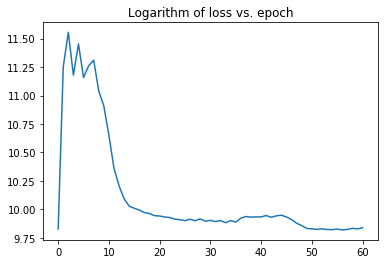

In [308]:
if __name__ == '__main__':
    # Plot loss
    plt.plot(list(range(epoch+1)),np.log(loss))
    plt.title("Logarithm of loss vs. epoch")
    plt.savefig("hw2_multi_logistic_loss")
    

In [312]:
# Confusion matrix
import sklearn.metrics as sk
matrix = sk.confusion_matrix(np.array(y_test).reshape(-1,1),y_predict)
matrix

array([[ 940,    0,    4,    1,    0,   23,    5,    3,    4,    0],
       [   0, 1081,   13,    7,    0,    5,    4,    0,   25,    0],
       [  10,    6,  892,   31,   16,    4,   14,   20,   39,    0],
       [   7,    2,   26,  868,    2,   56,    6,   17,   15,   11],
       [   2,    0,    5,    8,  847,    2,   26,    3,   26,   63],
       [  17,    5,   11,   54,   18,  678,    9,   17,   76,    7],
       [  20,    3,   23,    1,   17,   60,  822,    3,    9,    0],
       [   4,   15,   43,    7,    8,    0,    2,  912,   11,   26],
       [   9,   13,   27,   40,    8,   53,    8,   16,  781,   19],
       [   9,    5,   11,   18,   49,   17,    3,   43,   32,  822]],
      dtype=int64)